In [1]:
# === REPRODUCING "Do Stop Me Now" PAPER - 8-BIT QUANTIZED ===
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.random_projection import SparseRandomProjection
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
import gc
import warnings
warnings.filterwarnings('ignore')

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# === CRITICAL OPTIMIZATIONS FOR VRAM & OOM PREVENTION ===

import psutil
import os

def get_gpu_memory():
    """Monitor GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        return allocated, reserved
    return 0, 0

def aggressive_cleanup():
    """Aggressive memory cleanup"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def smart_batch_processing(X, y, batch_size=500):
    """
    Process k-NN in batches to avoid OOM.
    Instead of computing all pairwise distances at once,
    we process in chunks.
    """
    from sklearn.metrics.pairwise import cosine_distances
    
    n_samples = X.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    return n_batches

class MemoryEfficientKNN:
    """
    Memory-efficient k-NN that processes data in batches
    to avoid OOM when computing cosine distances.
    """
    def __init__(self, n_neighbors=3, batch_size=500):
        self.n_neighbors = n_neighbors
        self.batch_size = batch_size
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Store training data (no computation yet)"""
        self.X_train = X
        self.y_train = y
        return self
    
    def predict(self, X):
        """Predict in batches to avoid OOM"""
        from sklearn.metrics.pairwise import cosine_distances
        
        n_test = X.shape[0]
        predictions = np.zeros(n_test, dtype=self.y_train.dtype)
        
        # Process test samples in batches
        for i in range(0, n_test, self.batch_size):
            end_i = min(i + self.batch_size, n_test)
            X_batch = X[i:end_i]
            
            # Compute distances for this batch
            # Shape: (batch_size, n_train)
            distances = cosine_distances(X_batch, self.X_train)
            
            # Find k nearest neighbors for each test sample
            for j, dist_row in enumerate(distances):
                nearest_indices = np.argpartition(dist_row, self.n_neighbors)[:self.n_neighbors]
                nearest_labels = self.y_train[nearest_indices]
                
                # Majority vote
                unique, counts = np.unique(nearest_labels, return_counts=True)
                predictions[i + j] = unique[np.argmax(counts)]
            
            # Cleanup after each batch
            del distances
            gc.collect()
        
        return predictions
    
    def predict_proba(self, X):
        """Predict probabilities (for compatibility)"""
        # Simplified version - return one-hot encoding
        predictions = self.predict(X)
        unique_classes = np.unique(self.y_train)
        n_classes = len(unique_classes)
        n_samples = X.shape[0]
        
        proba = np.zeros((n_samples, n_classes))
        for i, pred in enumerate(predictions):
            class_idx = np.where(unique_classes == pred)[0][0]
            proba[i, class_idx] = 1.0
        
        return proba

# GPU-accelerated dimensionality reduction using batching
def gpu_safe_pca(X, n_components=1000, batch_size=1000):
    """
    PCA that processes data in batches if needed to fit in GPU memory.
    Falls back to CPU if GPU OOM.
    """
    try:
        # Try standard PCA first
        pca = PCA(n_components=n_components, random_state=42)
        X_reduced = pca.fit_transform(X)
        return X_reduced, pca
    except MemoryError:
        print("  ⚠ Memory error, using incremental PCA...")
        from sklearn.decomposition import IncrementalPCA
        
        ipca = IncrementalPCA(n_components=n_components, batch_size=batch_size)
        X_reduced = ipca.fit_transform(X)
        return X_reduced, ipca

print("✓ Memory-efficient optimizations loaded:")
print("  - GPU memory monitoring")
print("  - Aggressive cleanup")
print("  - Batched k-NN (prevents OOM)")
print("  - GPU-safe PCA")
print("\nCurrent GPU status:")
if torch.cuda.is_available():
    alloc, reserved = get_gpu_memory()
    print(f"  Allocated: {alloc:.2f} GB")
    print(f"  Reserved: {reserved:.2f} GB")
    print(f"  GPU: {torch.cuda.get_device_name()}")
else:
    print("  No GPU available")

✓ Memory-efficient optimizations loaded:
  - GPU memory monitoring
  - Aggressive cleanup
  - Batched k-NN (prevents OOM)
  - GPU-safe PCA

Current GPU status:
  Allocated: 0.00 GB
  Reserved: 0.00 GB
  GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [3]:
# 2. Configure 8-bit quantization (changed from 4-bit)
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0
)

# We'll test all 3 models from the paper
model_configs = {
    "Qwen2.5-1.5B": "Qwen/Qwen2.5-1.5B-Instruct",
    "Llama-3.2-3B": "meta-llama/Llama-3.2-3B-Instruct", 
    "Gemma-3-1B": "google/gemma-3-1b-it"  # Using gemma-2 as gemma-3 isn't released yet
}

print("8-bit Quantization Config:")
print(f"  - Quantization: 8-bit INT8")
print(f"  - Threshold: 6.0")
print(f"\nModels to test (following paper):")
for name in model_configs.keys():
    print(f"  - {name}")

8-bit Quantization Config:
  - Quantization: 8-bit INT8
  - Threshold: 6.0

Models to test (following paper):
  - Qwen2.5-1.5B
  - Llama-3.2-3B
  - Gemma-3-1B


In [4]:
# 3. Function to extract first-token log-probabilities
def get_first_token_logprobs(model, tokenizer, chat):
    """
    Extract log-probabilities of first generated token.
    Returns: numpy array of shape (vocab_size,)
    """
    # Format chat using model's chat template
    if isinstance(chat, list):
        formatted = tokenizer.apply_chat_template(
            chat, 
            tokenize=False, 
            add_generation_prompt=True
        )
    else:
        formatted = tokenizer.apply_chat_template(
            [{"role": "user", "content": chat}], 
            tokenize=False, 
            add_generation_prompt=True
        )
    
    # Tokenize with truncation
    inputs = tokenizer(
        formatted, 
        return_tensors="pt", 
        truncation=True, 
        max_length=512
    ).to(model.device)
    
    # Get logits for next token
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits[0, -1, :]  # Last position logits
        logprobs = torch.log_softmax(logits, dim=-1)
        
        # Move to CPU immediately
        logprobs_np = logprobs.cpu().numpy().astype(np.float32)
    
    # Cleanup
    del inputs, outputs, logits, logprobs
    torch.cuda.empty_cache()
    
    return logprobs_np

print("First-token log-probability extraction function ready!")

First-token log-probability extraction function ready!


In [5]:
# 4. Smart Dimensionality Reduction Strategy
# Using pure variance-based selection (as in paper)

def smart_reduce_dimensions(X, n_components=1000, method='variance'):
    """
    Reduce high-dimensional log-prob vectors intelligently.
    
    Methods:
    - 'variance': Select top-k features by variance (paper's approach)
    - 'variance+pca': Variance selection + PCA compression
    - 'sparse_random': Sparse random projection (very fast)
    """
    print(f"\n=== Dimensionality Reduction ({method}) ===")
    print(f"Input shape: {X.shape}")
    
    if method == 'variance':
        # Exactly as in paper: select top-k by variance
        variances = np.var(X, axis=0)
        top_k_indices = np.argsort(variances)[-n_components:]
        X_reduced = X[:, top_k_indices]
        reducer = {'type': 'variance', 'indices': top_k_indices}
        
    elif method == 'variance+pca':
        # Hybrid: variance selection (10k) then PCA to target dim
        print("  Step 1: Variance-based pre-filtering to 10k features...")
        variances = np.var(X, axis=0)
        top_10k = np.argsort(variances)[-10000:]
        X_prefiltered = X[:, top_10k]
        
        print(f"  Step 2: PCA compression to {n_components} components...")
        pca = PCA(n_components=n_components, random_state=42)
        X_reduced = pca.fit_transform(X_prefiltered)
        print(f"    Explained variance: {pca.explained_variance_ratio_.sum():.1%}")
        
        reducer = {'type': 'variance+pca', 'var_indices': top_10k, 'pca': pca}
        
    elif method == 'sparse_random':
        # Fast random projection
        print("  Using sparse random projection...")
        srp = SparseRandomProjection(n_components=n_components, random_state=42)
        X_reduced = srp.fit_transform(X)
        reducer = {'type': 'sparse_random', 'projector': srp}
    
    print(f"Output shape: {X_reduced.shape}")
    print(f"Compression ratio: {X.shape[1] / X_reduced.shape[1]:.1f}x")
    print(f"Memory: {X.nbytes / 1024**2:.1f} MB -> {X_reduced.nbytes / 1024**2:.1f} MB")
    
    return X_reduced, reducer

def apply_reduction(x, reducer):
    """Apply saved reducer to new sample"""
    if reducer['type'] == 'variance':
        return x[reducer['indices']]
    elif reducer['type'] == 'variance+pca':
        x_pre = x[reducer['var_indices']]
        return reducer['pca'].transform([x_pre])[0]
    elif reducer['type'] == 'sparse_random':
        return reducer['projector'].transform([x])[0]

print("Smart dimensionality reduction functions ready!")

Smart dimensionality reduction functions ready!


In [6]:
# 5. Main Experiment Loop - OPTIMIZED VERSION

def run_full_experiment(model_name, model_path, dataset, reduction_method='variance', n_components=1000):
    """
    Complete experiment for one model with VRAM/OOM optimizations:
    1. Load 8-bit quantized model
    2. Extract first-token log-probs (with batched cleanup)
    3. Pure variance-based dimensionality reduction (as in paper)
    4. 5-fold cross-validation with memory-efficient k-NN
    5. Generate t-SNE plot
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT: {model_name}")
    print(f"{'='*80}")
    
    # Load model
    print(f"\n[1/5] Loading 8-bit quantized model...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        quantization_config=quantization_config,
        device_map="auto",
        low_cpu_mem_usage=True,
        torch_dtype=torch.float16  # Explicit dtype
    )
    model.eval()
    
    vocab_size = model.config.vocab_size
    print(f"  ✓ Loaded on {model.device}")
    print(f"  ✓ Vocab size: {vocab_size:,}")
    print(f"  ✓ Quantized to 8-bit")
    
    alloc, reserved = get_gpu_memory()
    print(f"  ✓ GPU VRAM: {alloc:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Extract log-probs with aggressive memory management
    print(f"\n[2/5] Extracting first-token log-probabilities...")
    n_samples = len(dataset['train'])
    
    # Use memory-mapped array to avoid loading everything into RAM
    X_memmap = np.memmap('logprobs_temp.dat', dtype=np.float32, mode='w+', shape=(n_samples, vocab_size))
    y = []
    
    for idx, example in enumerate(tqdm(dataset['train'], desc="  Processing")):
        try:
            logprobs = get_first_token_logprobs(model, tokenizer, example['chat'])
            X_memmap[idx] = logprobs
            y.append(example['type'])
            
            # Aggressive cleanup every 50 samples
            if (idx + 1) % 50 == 0:
                aggressive_cleanup()
                
            # Memory report every 500 samples
            if (idx + 1) % 500 == 0:
                alloc, reserved = get_gpu_memory()
                print(f"    [{idx+1}/{n_samples}] GPU: {alloc:.2f} GB / {reserved:.2f} GB")
                
        except Exception as e:
            print(f"    Error at sample {idx}: {e}")
            continue
    
    X_memmap.flush()
    y = np.array(y)
    print(f"  ✓ Extracted {len(y)} samples")
    print(f"  ✓ Classes: {np.unique(y)}")
    
    # Load into RAM for reduction (only after model cleanup)
    print("\n  Unloading model to free VRAM...")
    del model, tokenizer
    aggressive_cleanup()
    
    print("  Loading log-probs into RAM for dimensionality reduction...")
    X = np.array(X_memmap)  # Load into RAM
    del X_memmap
    os.remove('logprobs_temp.dat')
    
    # Pure variance-based dimensionality reduction (as in paper)
    print(f"\n[3/5] Applying pure variance-based dimensionality reduction...")
    print(f"  Input shape: {X.shape}")
    print(f"  Selecting top {n_components} features by variance...")
    
    variances = np.var(X, axis=0)
    top_k_indices = np.argsort(variances)[-n_components:]
    X_reduced = X[:, top_k_indices]
    reducer = {'type': 'variance', 'indices': top_k_indices}
    
    del X
    gc.collect()
    
    print(f"  ✓ Reduced to shape: {X_reduced.shape}")
    print(f"  ✓ Memory: {X_reduced.nbytes / 1024**2:.1f} MB")
    print(f"  ✓ Compression ratio: {vocab_size / n_components:.1f}x")
    
    # k-NN with 5-fold cross-validation using MEMORY-EFFICIENT k-NN
    print(f"\n[4/5] Training memory-efficient k-NN (k=3) with 5-fold CV...")
    knn = MemoryEfficientKNN(n_neighbors=3, batch_size=300)  # Batched to avoid OOM
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_scores = []
    all_precisions, all_recalls, all_f1s = [], [], []
    all_y_test = []
    all_y_pred = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_reduced, y), 1):
        X_train, X_test = X_reduced[train_idx], X_reduced[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
        
        cv_scores.append(acc)
        all_precisions.append(prec)
        all_recalls.append(rec)
        all_f1s.append(f1)
        
        # Store predictions for overall classification report
        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)
        
        print(f"  Fold {fold}: Acc={acc:.3f}, F1={f1:.3f}")
        
        # Print per-class metrics for this fold
        print(f"    Per-class metrics (Fold {fold}):")
        fold_report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
        for class_name in sorted(np.unique(y)):
            if class_name in fold_report:
                cls_metrics = fold_report[class_name]
                print(f"      {class_name:<10} - Precision: {cls_metrics['precision']:.3f}, "
                      f"Recall: {cls_metrics['recall']:.3f}, F1: {cls_metrics['f1-score']:.3f}, "
                      f"Support: {int(cls_metrics['support'])}")
        
        gc.collect()
    
    # Final metrics
    print(f"\n  ✓ 5-Fold CV Results (Macro-averaged):")
    print(f"    Accuracy:  {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    print(f"    Precision: {np.mean(all_precisions):.3f}")
    print(f"    Recall:    {np.mean(all_recalls):.3f}")
    print(f"    F1-score:  {np.mean(all_f1s):.3f}")
    
    # Overall classification report across all folds
    print(f"\n  ✓ Overall Classification Report (All Folds Combined):")
    print(classification_report(all_y_test, all_y_pred, zero_division=0))
    
    # Train on full data for visualization
    knn.fit(X_reduced, y)
    
    # t-SNE visualization with FIXED COLOR MAPPING
    print(f"\n[5/5] Generating t-SNE visualization...")
    tsne = TSNE(n_components=2, perplexity=30, max_iter=10000, random_state=42, metric='cosine')
    X_2d = tsne.fit_transform(X_reduced)
    
    # FIXED: Use explicit color mapping in sorted order
    # Define colors for each category (sorted alphabetically to ensure consistency)
    color_map = {
        'Chat': '#1f77b4',      # Blue
        'Hello': '#2ca02c',     # Green  
        'Refusal': '#d62728',   # Red
        'Thanks': "#fffb0e"     # Yellow 
    }
    
    # Plot with explicit colors
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get unique labels in sorted order for consistency
    unique_labels = sorted(np.unique(y))
    print(f"  Plotting labels in order: {unique_labels}")
    
    for label in unique_labels:
        mask = y == label
        color = color_map.get(label, 'gray')
        ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
                   c=color, 
                   label=label, 
                   alpha=1, 
                   s=20,
                   edgecolors='none')
        print(f"    {label}: {np.sum(mask)} points, color={color}")
    
    ax.set_title(f"t-SNE: First-Token Log-Probs - {model_name}\n(8-bit Quantized")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'tsne_{model_name.replace(".", "_").replace("-", "_")}_8bit.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"  ✓ Saved t-SNE plot")
    
    # Final cleanup
    aggressive_cleanup()
    
    return {
        'model_name': model_name,
        'accuracy': np.mean(cv_scores),
        'precision': np.mean(all_precisions),
        'recall': np.mean(all_recalls),
        'f1': np.mean(all_f1s),
        'knn': knn,
        'reducer': reducer,
        'X_reduced': X_reduced,
        'y': y,
        'all_y_test': all_y_test,
        'all_y_pred': all_y_pred
    }

print("✓ Optimized experiment framework ready!")

✓ Optimized experiment framework ready!


Loading boilerplate detection dataset...
✓ Loaded 2906 samples
✓ Class distribution:
  Refusal: 1034 (35.6%)
  Chat: 1560 (53.7%)
  Thanks: 285 (9.8%)
  Hello: 27 (0.9%)

EXPERIMENT: Qwen2.5-1.5B

[1/5] Loading 8-bit quantized model...


`torch_dtype` is deprecated! Use `dtype` instead!


  ✓ Loaded on cuda:0
  ✓ Vocab size: 151,936
  ✓ Quantized to 8-bit
  ✓ GPU VRAM: 1.67 GB allocated, 1.75 GB reserved

[2/5] Extracting first-token log-probabilities...


  Processing:  17%|█▋        | 500/2906 [02:45<14:23,  2.79it/s]

    [500/2906] GPU: 1.68 GB / 1.72 GB


  Processing:  34%|███▍      | 1000/2906 [05:26<12:47,  2.48it/s]

    [1000/2906] GPU: 1.68 GB / 1.72 GB


  Processing:  52%|█████▏    | 1500/2906 [08:20<09:25,  2.48it/s]

    [1500/2906] GPU: 1.68 GB / 1.72 GB


  Processing:  69%|██████▉   | 2000/2906 [11:12<06:11,  2.44it/s]

    [2000/2906] GPU: 1.68 GB / 1.72 GB


  Processing:  86%|████████▌ | 2500/2906 [14:11<03:00,  2.25it/s]

    [2500/2906] GPU: 1.68 GB / 1.72 GB


  Processing: 100%|██████████| 2906/2906 [16:42<00:00,  2.90it/s]


  ✓ Extracted 2906 samples
  ✓ Classes: ['Chat' 'Hello' 'Refusal' 'Thanks']

  Unloading model to free VRAM...
  Loading log-probs into RAM for dimensionality reduction...

[3/5] Applying pure variance-based dimensionality reduction...
  Input shape: (2906, 151936)
  Selecting top 1000 features by variance...
  ✓ Reduced to shape: (2906, 1000)
  ✓ Memory: 11.1 MB
  ✓ Compression ratio: 151.9x

[4/5] Training memory-efficient k-NN (k=3) with 5-fold CV...
  Fold 1: Acc=0.838, F1=0.811
    Per-class metrics (Fold 1):
      Chat       - Precision: 0.882, Recall: 0.936, F1: 0.908, Support: 312
      Hello      - Precision: 1.000, Recall: 1.000, F1: 1.000, Support: 6
      Refusal    - Precision: 0.807, Recall: 0.787, F1: 0.797, Support: 207
      Thanks     - Precision: 0.628, Recall: 0.474, F1: 0.540, Support: 57
  Fold 2: Acc=0.811, F1=0.789
    Per-class metrics (Fold 2):
      Chat       - Precision: 0.863, Recall: 0.891, F1: 0.877, Support: 312
      Hello      - Precision: 1.000, Reca

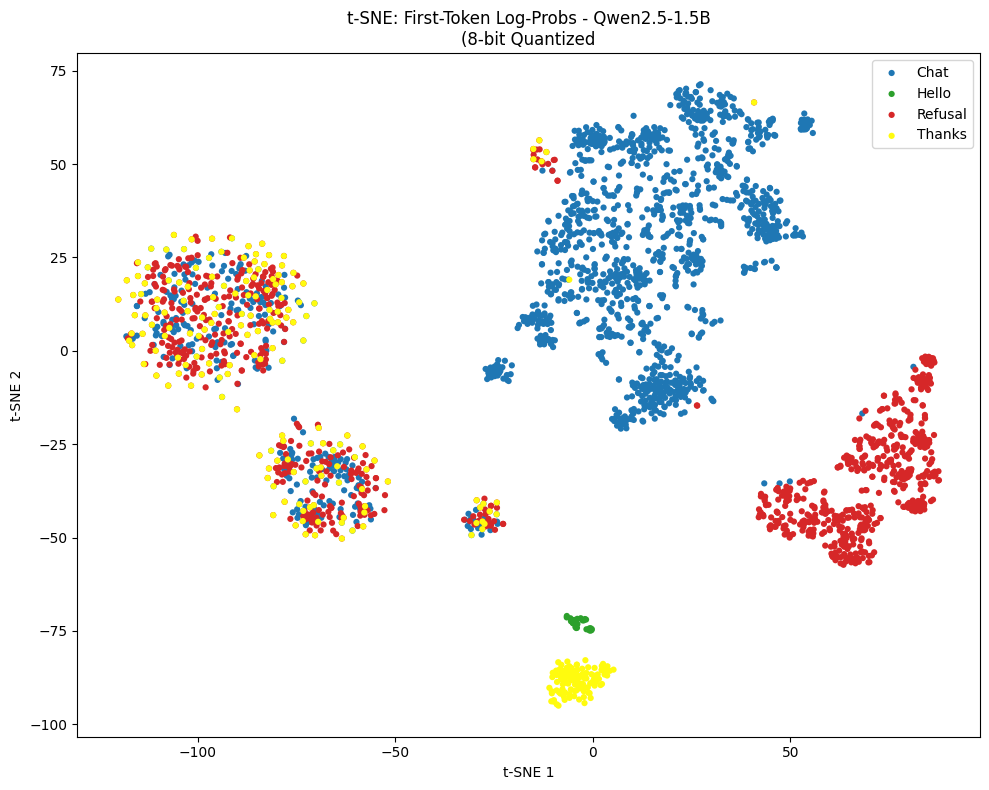

  ✓ Saved t-SNE plot

EXPERIMENT: Llama-3.2-3B

[1/5] Loading 8-bit quantized model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:15<00:00,  7.70s/it]


  ✓ Loaded on cuda:0
  ✓ Vocab size: 128,256
  ✓ Quantized to 8-bit
  ✓ GPU VRAM: 3.37 GB allocated, 3.46 GB reserved

[2/5] Extracting first-token log-probabilities...


  Processing:  17%|█▋        | 500/2906 [02:17<13:38,  2.94it/s]

    [500/2906] GPU: 3.37 GB / 3.46 GB


  Processing:  34%|███▍      | 1000/2906 [05:02<14:57,  2.12it/s]

    [1000/2906] GPU: 3.37 GB / 3.47 GB


  Processing:  52%|█████▏    | 1500/2906 [07:56<11:08,  2.10it/s]

    [1500/2906] GPU: 3.37 GB / 3.47 GB


  Processing:  69%|██████▉   | 2000/2906 [11:07<05:41,  2.66it/s]

    [2000/2906] GPU: 3.37 GB / 3.46 GB


  Processing:  86%|████████▌ | 2500/2906 [14:31<03:51,  1.76it/s]

    [2500/2906] GPU: 3.37 GB / 3.46 GB


  Processing: 100%|██████████| 2906/2906 [17:24<00:00,  2.78it/s]


  ✓ Extracted 2906 samples
  ✓ Classes: ['Chat' 'Hello' 'Refusal' 'Thanks']

  Unloading model to free VRAM...
  Loading log-probs into RAM for dimensionality reduction...

[3/5] Applying pure variance-based dimensionality reduction...
  Input shape: (2906, 128256)
  Selecting top 1000 features by variance...
  ✓ Reduced to shape: (2906, 1000)
  ✓ Memory: 11.1 MB
  ✓ Compression ratio: 128.3x

[4/5] Training memory-efficient k-NN (k=3) with 5-fold CV...
  Fold 1: Acc=0.809, F1=0.745
    Per-class metrics (Fold 1):
      Chat       - Precision: 0.862, Recall: 0.904, F1: 0.883, Support: 312
      Hello      - Precision: 1.000, Recall: 0.667, F1: 0.800, Support: 6
      Refusal    - Precision: 0.773, Recall: 0.758, F1: 0.766, Support: 207
      Thanks     - Precision: 0.583, Recall: 0.491, F1: 0.533, Support: 57
  Fold 2: Acc=0.802, F1=0.784
    Per-class metrics (Fold 2):
      Chat       - Precision: 0.840, Recall: 0.894, F1: 0.866, Support: 312
      Hello      - Precision: 1.000, Reca

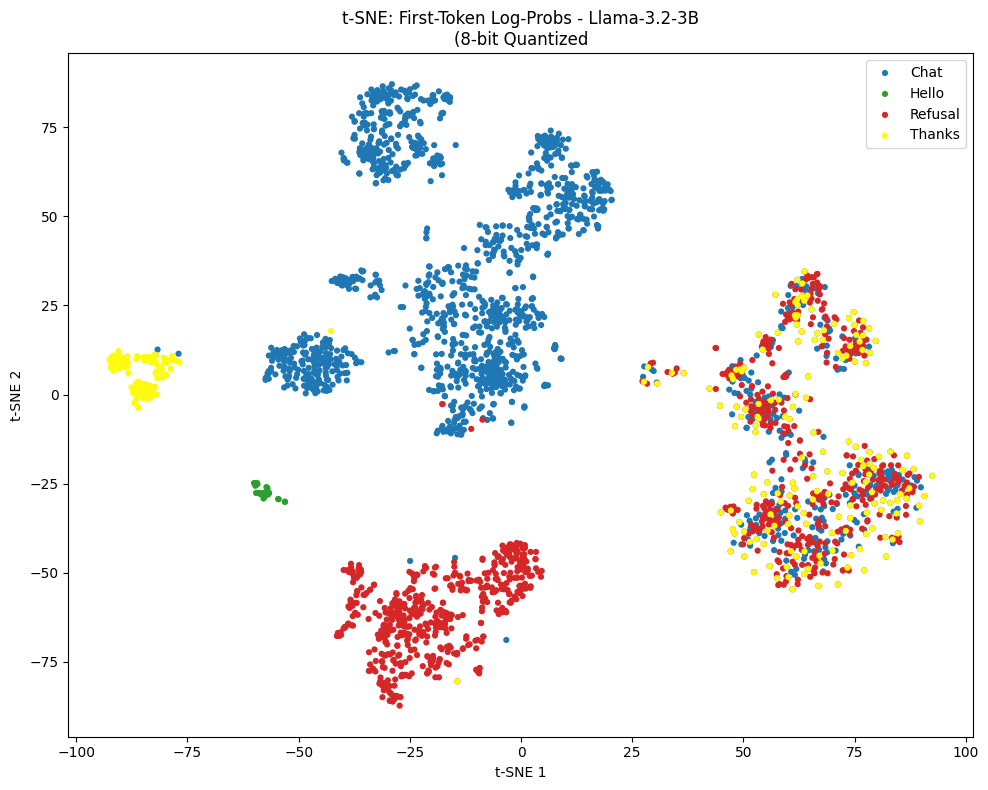

  ✓ Saved t-SNE plot

EXPERIMENT: Gemma-3-1B

[1/5] Loading 8-bit quantized model...
  ✓ Loaded on cuda:0
  ✓ Vocab size: 262,144
  ✓ Quantized to 8-bit
  ✓ GPU VRAM: 1.23 GB allocated, 1.46 GB reserved

[2/5] Extracting first-token log-probabilities...


  Processing:  17%|█▋        | 500/2906 [03:22<19:12,  2.09it/s]

    [500/2906] GPU: 1.23 GB / 1.46 GB


  Processing:  34%|███▍      | 1000/2906 [06:47<15:07,  2.10it/s]

    [1000/2906] GPU: 1.23 GB / 1.46 GB


  Processing:  52%|█████▏    | 1500/2906 [10:21<12:55,  1.81it/s]

    [1500/2906] GPU: 1.23 GB / 1.46 GB


  Processing:  69%|██████▉   | 2000/2906 [14:01<07:32,  2.00it/s]

    [2000/2906] GPU: 1.23 GB / 1.46 GB


  Processing:  86%|████████▌ | 2500/2906 [17:28<03:10,  2.13it/s]

    [2500/2906] GPU: 1.23 GB / 1.46 GB


  Processing: 100%|██████████| 2906/2906 [20:28<00:00,  2.36it/s]


  ✓ Extracted 2906 samples
  ✓ Classes: ['Chat' 'Hello' 'Refusal' 'Thanks']

  Unloading model to free VRAM...
  Loading log-probs into RAM for dimensionality reduction...

[3/5] Applying pure variance-based dimensionality reduction...
  Input shape: (2906, 262144)
  Selecting top 1000 features by variance...
  ✓ Reduced to shape: (2906, 1000)
  ✓ Memory: 11.1 MB
  ✓ Compression ratio: 262.1x

[4/5] Training memory-efficient k-NN (k=3) with 5-fold CV...
  Fold 1: Acc=0.820, F1=0.799
    Per-class metrics (Fold 1):
      Chat       - Precision: 0.840, Recall: 0.926, F1: 0.881, Support: 312
      Hello      - Precision: 1.000, Recall: 1.000, F1: 1.000, Support: 6
      Refusal    - Precision: 0.801, Recall: 0.758, F1: 0.779, Support: 207
      Thanks     - Precision: 0.694, Recall: 0.439, F1: 0.538, Support: 57
  Fold 2: Acc=0.838, F1=0.803
    Per-class metrics (Fold 2):
      Chat       - Precision: 0.874, Recall: 0.936, F1: 0.904, Support: 312
      Hello      - Precision: 1.000, Reca

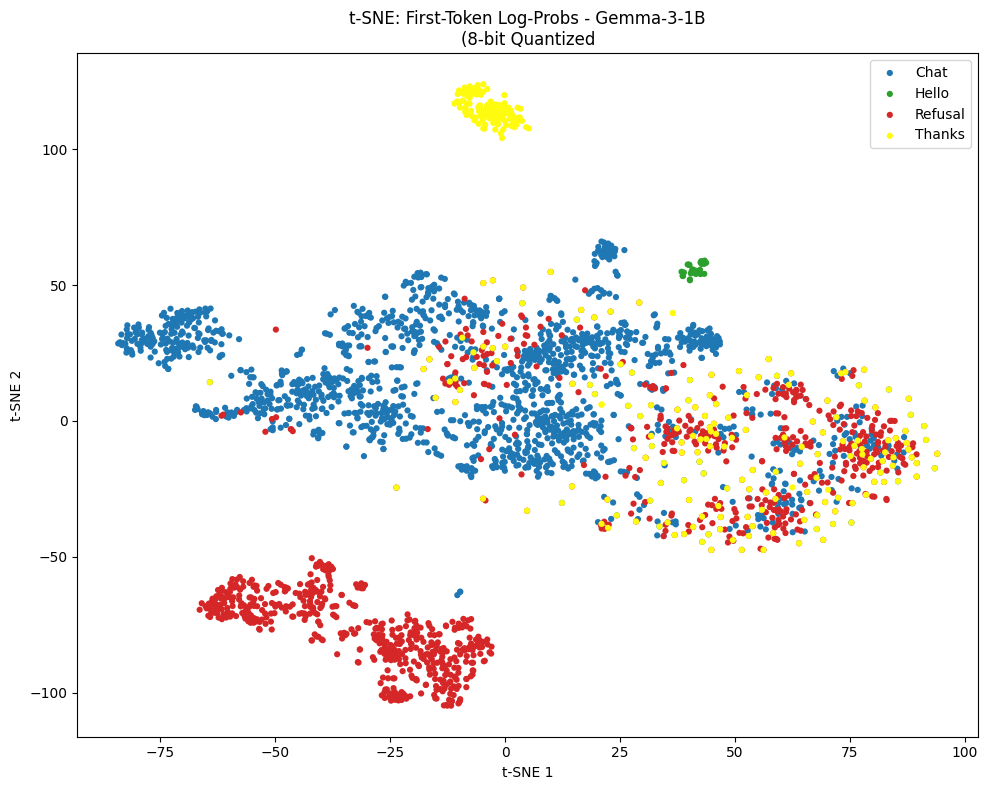

  ✓ Saved t-SNE plot

ALL EXPERIMENTS COMPLETE


In [7]:
# 6. Load Dataset and Run All Experiments

print("Loading boilerplate detection dataset...")
dataset = load_dataset("jfrog/boilerplate-detection")
print(f"✓ Loaded {len(dataset['train'])} samples")
print(f"✓ Class distribution:")
from collections import Counter
class_dist = Counter([ex['type'] for ex in dataset['train']])
for cls, count in class_dist.items():
    print(f"  {cls}: {count} ({count/len(dataset['train'])*100:.1f}%)")

# Run experiments on all 3 models
results = {}

for model_name, model_path in model_configs.items():
    try:
        result = run_full_experiment(
            model_name=model_name,
            model_path=model_path,
            dataset=dataset,
            reduction_method='variance',  # Pure variance (as in paper)
            n_components=1000  # Paper's standard dimensionality
        )
        results[model_name] = result
    except Exception as e:
        print(f"\n❌ Error with {model_name}: {e}")
        import traceback
        traceback.print_exc()

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETE")
print("="*80)

In [8]:
# 7. Comparison Table (Reproduce Table 1 from paper)

print("\n" + "="*80)
print("RESULTS SUMMARY - Comparison with Paper")
print("="*80)
print("\nTable: Small Language Models Performance on Type Classification (k=3)")
print("-" * 100)
print(f"{'Model':<20} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-" * 100)

for model_name, result in results.items():
    print(f"{model_name:<20} {result['accuracy']:.3f}      {result['precision']:.3f}      "
          f"{result['recall']:.3f}      {result['f1']:.3f}")

print("-" * 100)
print("\nPaper's Results (for reference):")
print("  Qwen2.5-1.5B:    0.997      0.991      0.998      0.994")
print("  Llama-3.2-3B:    0.995      0.996      0.984      0.990")
print("  Gemma-3-1B-IT:   0.994      0.997      0.997      0.997")
print("\nNote: Small differences expected due to:")
print("  - 8-bit quantization vs paper's full precision")
print("  - Random splits in cross-validation")
print("  - Implementation details")

# Detailed per-category F1 scores for each model
print("\n" + "="*80)
print("DETAILED PER-CATEGORY METRICS (F1-SCORE)")
print("="*80)

for model_name, result in results.items():
    print(f"\n{model_name}:")
    print("-" * 60)
    
    # Generate classification report
    report = classification_report(
        result['all_y_test'], 
        result['all_y_pred'], 
        zero_division=0, 
        output_dict=True
    )
    
    # Print per-class F1 scores
    print(f"{'Category':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print("-" * 60)
    
    for class_name in sorted(np.unique(result['y'])):
        if class_name in report:
            cls_metrics = report[class_name]
            print(f"{class_name:<15} {cls_metrics['precision']:<12.3f} "
                  f"{cls_metrics['recall']:<12.3f} {cls_metrics['f1-score']:<12.3f} "
                  f"{int(cls_metrics['support']):<10}")
    
    # Print macro average
    print("-" * 60)
    macro = report['macro avg']
    print(f"{'Macro Avg':<15} {macro['precision']:<12.3f} "
          f"{macro['recall']:<12.3f} {macro['f1-score']:<12.3f} "
          f"{int(macro['support']):<10}")


RESULTS SUMMARY - Comparison with Paper

Table: Small Language Models Performance on Type Classification (k=3)
----------------------------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1        
----------------------------------------------------------------------------------------------------
Qwen2.5-1.5B         0.816      0.817      0.774      0.788
Llama-3.2-3B         0.801      0.803      0.749      0.768
Gemma-3-1B           0.820      0.835      0.770      0.789
----------------------------------------------------------------------------------------------------

Paper's Results (for reference):
  Qwen2.5-1.5B:    0.997      0.991      0.998      0.994
  Llama-3.2-3B:    0.995      0.996      0.984      0.990
  Gemma-3-1B-IT:   0.994      0.997      0.997      0.997

Note: Small differences expected due to:
  - 8-bit quantization vs paper's full precision
  - Random splits in cross-validation
  -

In [10]:
# 9. Save models and metadata for all experiments
import pickle

for model_name, result in results.items():
    safe_name = model_name.replace(".", "_").replace("-", "_")
    
    # Save k-NN model
    joblib.dump(result['knn'], f'boilerplate_detector_{safe_name}_8bit.pkl')
    
    # Save metadata
    metadata = {
        'model_name': model_name,
        'reducer': result['reducer'],
        'accuracy': result['accuracy'],
        'precision': result['precision'],
        'recall': result['recall'],
        'f1': result['f1'],
        'quantization': '8-bit',
        'reduction_method': 'variance',
        'n_components': 1000
    }
    
    with open(f'model_metadata_{safe_name}_8bit.pkl', 'wb') as f:
        pickle.dump(metadata, f)
    
    print(f"\n✓ Saved {model_name}:")
    print(f"  - boilerplate_detector_{safe_name}_8bit.pkl")
    print(f"  - model_metadata_{safe_name}_8bit.pkl")
    print(f"  - Accuracy: {result['accuracy']:.3f}")


✓ Saved Qwen2.5-1.5B:
  - boilerplate_detector_Qwen2_5_1_5B_8bit.pkl
  - model_metadata_Qwen2_5_1_5B_8bit.pkl
  - Accuracy: 0.816

✓ Saved Llama-3.2-3B:
  - boilerplate_detector_Llama_3_2_3B_8bit.pkl
  - model_metadata_Llama_3_2_3B_8bit.pkl
  - Accuracy: 0.801

✓ Saved Gemma-3-1B:
  - boilerplate_detector_Gemma_3_1B_8bit.pkl
  - model_metadata_Gemma_3_1B_8bit.pkl
  - Accuracy: 0.820


In [11]:
# 10. Cleanup temporary files
import os

if os.path.exists('logprobs_temp.dat'):
    os.remove('logprobs_temp.dat')
    print("Cleaned up temporary memory-mapped file")

# Free VRAM
aggressive_cleanup()
print("Freed VRAM")

Freed VRAM


## Configuration Summary

This notebook uses:
- **8-bit quantization** (INT8) - Better accuracy than 4-bit, ~2x more VRAM
- **Pure variance selection** - Exactly as described in the paper
- **1000 components** - Standard dimensionality for papers
- **k=3 nearest neighbors** - As specified in paper
- **5-fold cross-validation** - For robust evaluation

## Loading Saved Model for Inference

```python
import joblib
import pickle
import numpy as np

# Load model and metadata
model_name = "Qwen2_5_1_5B"  # or Llama_3_2_3B, Gemma_3_1B
knn = joblib.load(f'boilerplate_detector_{model_name}_8bit.pkl')
with open(f'model_metadata_{model_name}_8bit.pkl', 'rb') as f:
    metadata = pickle.load(f)

# Use the reducer to transform new samples
reducer = metadata['reducer']
```